In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
RANDOM_SEED = 4
INIT_ALPHA = 0.1

# Functions

In [3]:
def generate_random_rgb_grid(height: int, width: int):
    np.random.seed(RANDOM_SEED)
    imgdata = np.random.random((height, width, 3))
    return imgdata

def vector_norm(v) -> float:
    """Implemented this little one so I won't call np.linalg.norm :) """
    return np.sqrt( np.sum((v)**2) )

def get_distances_point_to_grid(point, grid):
    """Calculate distances of a RGB point to a single RGB 2d matrix"""
    grid_shape = grid.shape[:2]
    point_dims = grid.shape[-1]
    diffs_grid = point - grid
    diffs_flatten = diffs_grid.reshape(-1,point_dims)
    norms_flatten = np.apply_along_axis(vector_norm, 1, diffs_flatten)
    norms_grid = norms_flatten.reshape(grid_shape)
    return norms_grid

def get_distances_grid_to_point(grid, point):
    """Reverse of the above, for convinience and readability"""
    distances = 0.0 - get_distances_point_to_grid(point, grid)
    return distances

def array_argmin(a: np.array) -> np.array:
    """Get the index of the smallest number in a 2d array"""
    ind = np.unravel_index(np.argmin(a, axis=None), a.shape)
    return ind

def get_bmu_coords(point, grid):
    """Get the coordinates of BMU"""
    distance_grid = get_distances_point_to_grid(point, grid)
    min_index = array_argmin(distance_grid)
    return min_index

def get_coords_matrix(matrix_shape) -> np.array:
    """Generate a 2d coordinates matrix"""
    return np.vstack(np.indices(matrix_shape)).reshape(2,-1).T.reshape(matrix_shape[0], matrix_shape[1], 2)


def get_initial_radius(data: np.array) -> float:
    """Self explainatory"""
    return (max(data.shape)+1.0)/2

def get_time_step_params(sigma0: float, alpha0: float, lambda_: float, t: int) -> tuple:
    """Get the sigma and alpha for a give time step t"""
    if t == 0:
        return sigma0, alpha0
    sigma = sigma0 * np.exp(-(t/lambda_))
    alpha = alpha0 * np.exp(-(t/lambda_))
    return sigma, alpha

def get_influences(distances: np.array, sigma: float) -> np.array:
    """Get influences matrix given the distance matrix to BMU and Sigma"""
    influences = np.exp( - distances**2 / (2 * sigma**2) )
    return influences

def get_incre_weights(alpha: float, influences: np.array, vector: np.array, weights: np.array) -> np.array:
    """Calculate incremental weights"""
    vector_size = weights.shape[-1]
    return ((vector - weights).reshape(-1, vector_size) * influences.reshape(-1,1)).reshape(weights.shape) * alpha

# Thoughts on the implementation

This whole implementation has two for loops, one for iterating through the training examples, the other for the iterations itself. This is probably as vectorising as it gets with numpy, as I haven't thought up a way to vectorise finding the BMU. 

For further performance improvement, I suppose we could do a tensorflow implementation?

# Training Loops

In [4]:
def train_end_to_end(height: int, width: int, max_iter: int, train_data: np.array) -> np.array:
    weights = generate_random_rgb_grid(height, width)

    sigma0 = get_initial_radius(weights)
    alpha0 = INIT_ALPHA
    lambda_ = max_iter / np.log(sigma0)
    coords_matrix = get_coords_matrix(weights.shape[:2])

    for t in range(max_iter):
        sigma, alpha = get_time_step_params(sigma0, alpha0, lambda_, t)

        for i in range(train_data.shape[0]):
            vector = train_data[i,:]
            bmu_coords = get_bmu_coords(vector, weights)
            distances_to_bmu = get_distances_grid_to_point(coords_matrix, bmu_coords)
            influences = get_influences(distances_to_bmu, sigma)
            incre_weights = get_incre_weights(alpha, influences, vector, weights)
            weights = weights + incre_weights

    plt.imshow(weights)
    return weights

# Experiements

## 20 training examples, 10x10 matrix, 100 iterations

CPU times: user 3.62 s, sys: 25.8 ms, total: 3.64 s
Wall time: 3.64 s


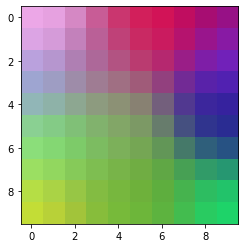

In [5]:
%%time

train_data = generate_random_rgb_grid(20, 1).reshape(-1,3)

final_weights = train_end_to_end(10, 10, 100, train_data)

## 100 training examples, 10x20 matrix, 100 iterations

CPU times: user 32.4 s, sys: 111 ms, total: 32.5 s
Wall time: 32.6 s


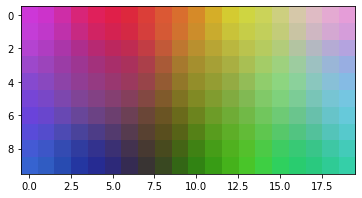

In [6]:
%%time

train_data = generate_random_rgb_grid(100, 1).reshape(-1,3)

final_weights = train_end_to_end(10, 20, 100, train_data)

# 20 training examples, 100x100 matrix, 10 iterations

This should scale linearly with number of iterations. So it should take less than an hour to run 1000 iterations, we good to go!

CPU times: user 31.4 s, sys: 35.1 ms, total: 31.4 s
Wall time: 31.5 s


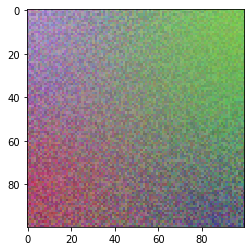

In [27]:
%%time

train_data = generate_random_rgb_grid(20, 1).reshape(-1,3)

final_weights = train_end_to_end(100, 100, 10, train_data)

# 20 training examples, 100x100 matrix, 100 iterations

Huh, only took 5 minutes, I guess the overhead is huge, or my Macbook's performance is a bit shaky.

CPU times: user 5min 4s, sys: 164 ms, total: 5min 4s
Wall time: 5min 4s


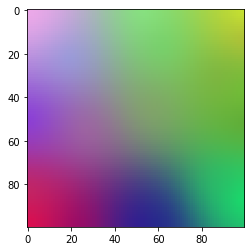

In [28]:
%%time

train_data = generate_random_rgb_grid(20, 1).reshape(-1,3)

final_weights = train_end_to_end(100, 100, 100, train_data)